In [50]:
# autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [51]:
import numpy as np

N = 500_000
DATASET = {}

# generate data from beta distribution
set_of_parameters = [(0.5, 0.5), (1, 3), (2, 2), (2, 5)]  # from Figure 1 https://arxiv.org/pdf/2302.06943
for parameters in set_of_parameters:
    data = np.random.beta(*parameters, N)
    data = np.sort(data)
    DATASET[f'Beta_{parameters[0]}_{parameters[1]}'] = {"data": data}

# generate data from mixture of beta distributions
number_of_centers = [np.random.uniform(0, 10 ** 3, 10),
                     np.random.uniform(0, 10 ** 3, 100),
                     np.random.uniform(0, 10 ** 3, 1000)]
n_per_center = [[N // len(c)] * len(c) + [N % len(c)] for c in number_of_centers]
width = 10
for centers, n_per_c in zip(number_of_centers, n_per_center):
    data = np.concatenate([loc + np.random.beta(2, 5, size=n) for loc, n in zip(centers, n_per_c)])
    data = np.sort(data)
    DATASET[f'{len(centers)}_Mixture_Beta_2_5'] = {"data": data}

# Post Process to get the Bounds and minimum gap

In [52]:
# get a valid minimum gap by scaling
MIN_G = 1
for key, data in DATASET.items():
    array = data["data"]
    g = np.min(np.diff(array))
    scale = MIN_G / g
    DATASET[key]["data"] = array * scale  # Update the scaled array back into the dataset
    new_gap = np.min(np.diff(DATASET[key]["data"]))

In [53]:
BOUND = (0, 2 ** 64 - 1)
# check if the bound is valid
for key, data in DATASET.items():
    array = data["data"]
    assert np.all(array >= BOUND[0]) and np.all(array <= BOUND[1]), f"Invalid bounds for {key}"
    print(f"Valid bounds for {key}: {BOUND}")

Valid bounds for Beta_0.5_0.5: (0, 18446744073709551615)
Valid bounds for Beta_1_3: (0, 18446744073709551615)
Valid bounds for Beta_2_2: (0, 18446744073709551615)
Valid bounds for Beta_2_5: (0, 18446744073709551615)
Valid bounds for 10_Mixture_Beta_2_5: (0, 18446744073709551615)
Valid bounds for 100_Mixture_Beta_2_5: (0, 18446744073709551615)
Valid bounds for 1000_Mixture_Beta_2_5: (0, 18446744073709551615)


# Set Privacy Budgets

We propose $\varepsilon, \delta$ that are used in SliceQuantiles, and compute the highest $\rho$ for zCDP that implies the same $\varepsilon, \delta$.

In [54]:
from scipy.optimize import root_scalar


def get_max_rho(eps, delta):
    """
    Get the maximum rho for a given epsilon and delta.
    """
    epsilon_func = lambda rho: rho + np.sqrt(4 * rho * np.log(np.sqrt(np.pi * rho) / delta)) - eps

    # Use a numerical solver to find the root of epsilon_func
    result = root_scalar(epsilon_func, bracket=[1e-10, 10], method='brentq')

    if result.converged:
        return result.root
    else:
        raise ValueError("Failed to find a valid rho for the given epsilon and delta.")


eps = 1.
delta = 1e-20
rho = get_max_rho(eps, delta)
print("For eps = {}, delta = {}, max rho = {}".format(eps, delta, rho))

For eps = 1.0, delta = 1e-20, max rho = 0.005614013829012967


# Hyperparameters

In [55]:
EPS = 1.
DELTA = 1e-20
RHO = get_max_rho(EPS, DELTA)
M_LIST = range(10, 300, 10)
Q_LIST = [np.linspace(0, 1, num=m + 2)[1:-1] for m in M_LIST]
SWAP = False
NUM_EXPERIMENTS = 25

In [56]:
records = []  # to store the records of each experiment

In [57]:
import math


def get_statistics(X: np.ndarray, quantiles: np.ndarray, estimates: np.ndarray) -> float:
    """
    Compute the maximum rank error and the mean absolute rank error between the true quantiles and the estimated quantiles.
    :param X: data set
    :param quantiles: a list of quantiles (values in [0, 1])
    :param estimates: a list of estimated qth-quantiles (values in X)
    :return: a dictionary with the maximum rank error and the mean absolute rank error
    """
    # sort the data
    X = np.sort(X)
    n = len(X)

    # for each result, get the position of the closest element in the sorted array
    positions = np.searchsorted(X, estimates)
    true_positions = [math.floor(q * n) for q in quantiles]

    # compute the normalized rank error
    rank_errors = np.abs(positions - true_positions)

    # get statistics
    max_rank_error = np.max(rank_errors)
    mean_rank_error = np.mean(rank_errors)
    output = {
        'max_error':  max_rank_error,
        'mean_error': mean_rank_error  # Kaplan et al. uses this
    }
    return output


# Run SliceQuantiles

## Check correcteness of the privacy parameters

In [58]:
from our_mechanism import SliceQuantile

# Check if the privacy parameters are valid for any values of m
for m, q_list in zip(M_LIST, Q_LIST):
    mechanism = SliceQuantile(bound=BOUND, n=N, m=m, eps=EPS, split=0.5, swap=SWAP, g=MIN_G)
    if not mechanism.is_delta_approximate_DP(delta=DELTA, q_list=q_list):
        raise ValueError(f"At m={m} failed to find a valid delta approximate DP.")
print("All privacy parameters are valid for the given m values.")

All privacy parameters are valid for the given m values.


## Run the experiments

In [59]:
from tqdm import tqdm

for key, data in tqdm(DATASET.items(), total=len(DATASET), desc="Datasets"):
    X = data["data"]
    for i, (m, q_list) in enumerate(zip(M_LIST, Q_LIST)):
        mechanism = SliceQuantile(bound=BOUND, n=N, m=m, eps=EPS, split=0.5, swap=SWAP, g=MIN_G)
        for j in range(NUM_EXPERIMENTS):
            estimates = mechanism.approximate_mechanism(X, q_list=q_list, delta=DELTA, verbose=True)
            statistics = get_statistics(X, quantiles=q_list, estimates=estimates)
            records.append({
                "dataset":    key,
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "SliceQuantile",
            })

Datasets: 100%|██████████| 7/7 [03:45<00:00, 32.21s/it]


# Run Approximate Quantiles, from Kaplan et al.

In [60]:
from DP_AQ import approximate_quantiles_algo

for key, data in tqdm(DATASET.items(), total=len(DATASET), desc="Datasets"):
    X = data["data"]
    for i, (m, q_list) in enumerate(zip(M_LIST, Q_LIST)):
        for j in range(NUM_EXPERIMENTS):
            estimates = approximate_quantiles_algo(array=X, quantiles=q_list, bounds=BOUND,
                                                   epsilon=RHO, swap=SWAP, cdp=True)
            statistics = get_statistics(X, quantiles=q_list, estimates=estimates)
            records.append({
                "dataset":    key,
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "Approximate Quantiles",
            })

Datasets: 100%|██████████| 7/7 [12:41<00:00, 108.83s/it]


# Run Histogram Approach

In [61]:
for key, data in tqdm(DATASET.items(), total=len(DATASET), desc="Datasets"):
    X = data["data"]

    # Use auto binning
    bin_edges = np.histogram_bin_edges(X, bins='auto')
    hist, edges = np.histogram(X, bins=bin_edges)
    bin_widths = np.diff(edges)  # Precompute bin widths for interpolation

    for i, (m, q_list) in enumerate(zip(M_LIST, Q_LIST)):
        for j in range(NUM_EXPERIMENTS):
            # Add noise to the histogram for differential privacy
            noisy_hist = hist + np.random.normal(0, np.sqrt(1 / (2 * rho)), len(hist))

            # Precompute cumulative sums for rank calculation
            cumulative_counts = np.cumsum(noisy_hist)
            total_count = cumulative_counts[-1]

            estimates = []
            for q in q_list:
                rank = math.floor(q * total_count)

                # Find the bin containing the rank using binary search
                bin_index = np.searchsorted(cumulative_counts, rank, side='right')

                # Compute the estimate within the bin
                if bin_index < len(bin_edges) - 1:
                    lower_edge = edges[bin_index]
                    upper_edge = edges[bin_index + 1]
                    bin_count = noisy_hist[bin_index]
                    count_before_bin = cumulative_counts[bin_index - 1] if bin_index > 0 else 0

                    # Interpolate within the bin
                    if bin_count > 0:
                        fraction = (rank - count_before_bin) / bin_count
                        estimate = lower_edge + fraction * (upper_edge - lower_edge)
                    else:
                        estimate = lower_edge  # Fallback if bin_count is zero
                    estimates.append(estimate)

            statistics = get_statistics(X, quantiles=q_list, estimates=estimates)
            records.append({
                "dataset":    key,
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "Gaussian Histogram",
            })# 'auto' selects

Datasets: 100%|██████████| 7/7 [01:32<00:00, 13.17s/it]


# Plot the results

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

DF = pd.DataFrame(records)

## Max Error

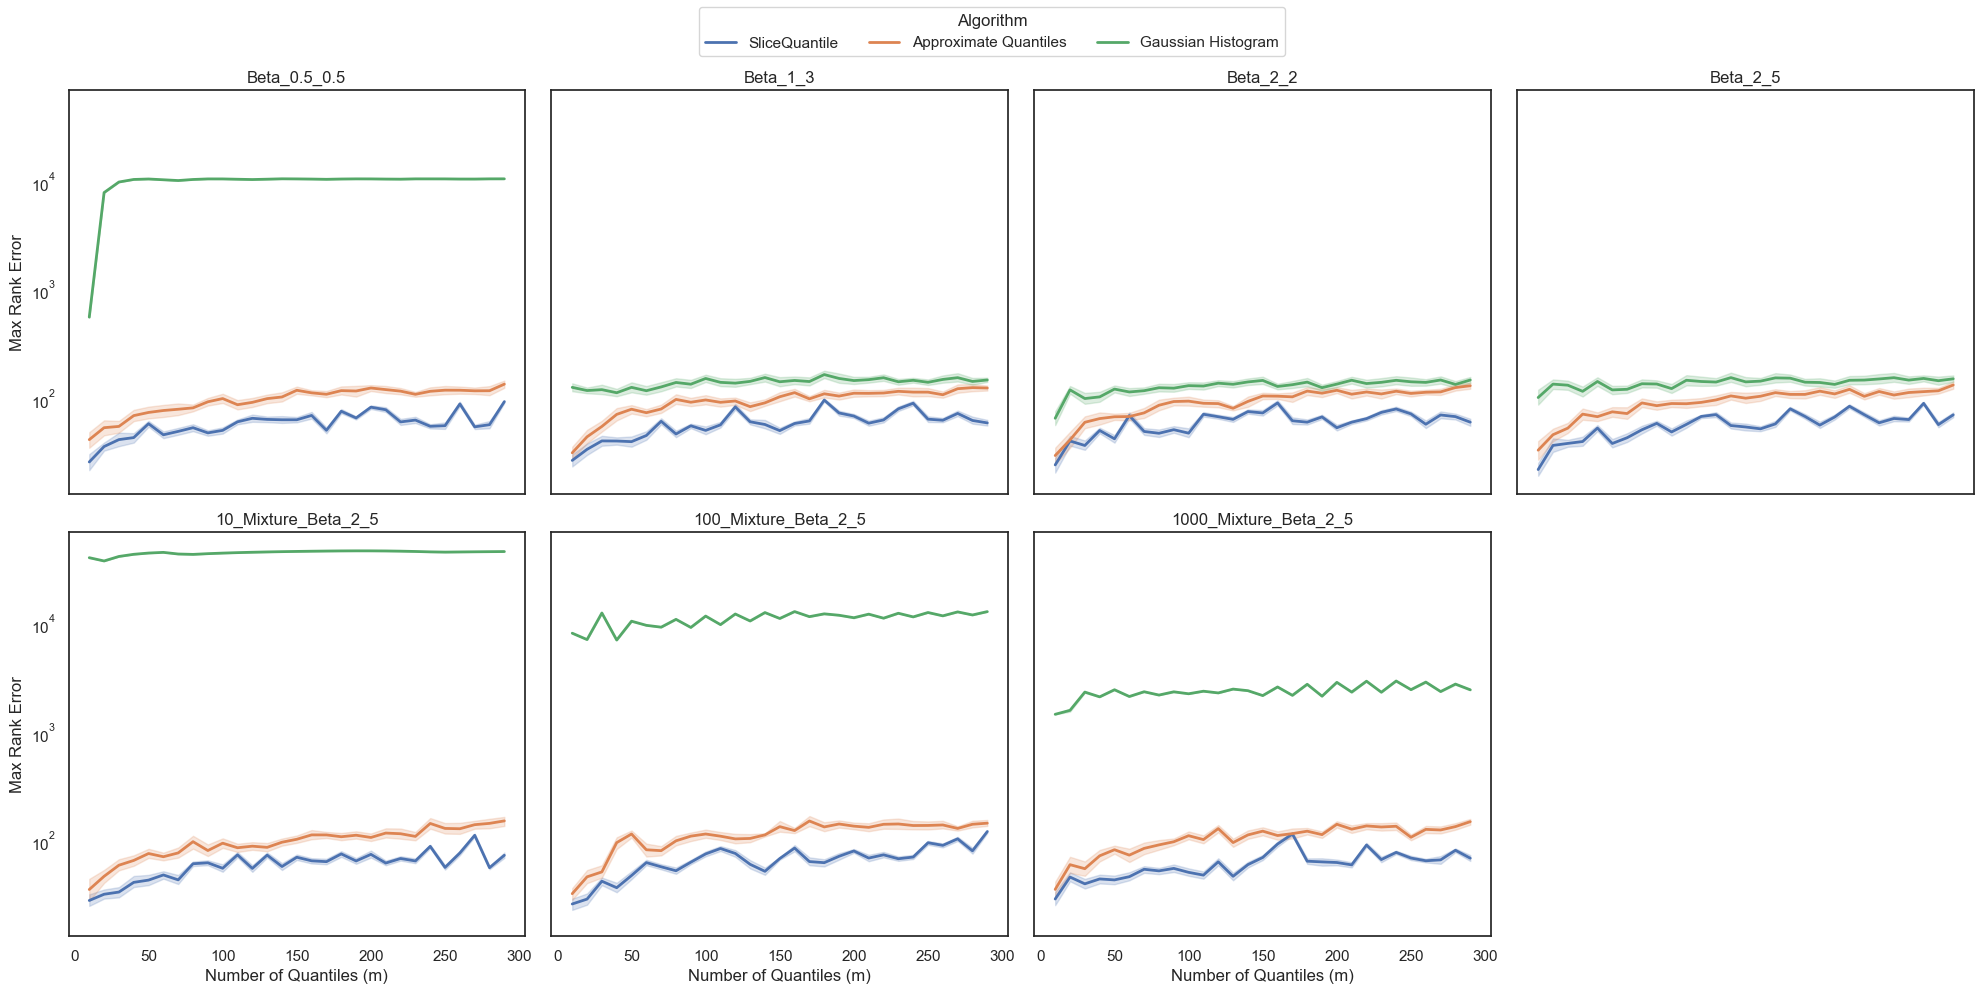

In [63]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each dataset
for i, (key, data) in enumerate(DATASET.items()):
    ax = axes[i]
    df = DF[DF["dataset"] == key]
    sns.lineplot(
        data=df,
        x="m",
        y="max_error",
        hue="Algorithm",
        errorbar=('ci', 95),  # confidence interval 95%
        linewidth=2,
        ax=ax,
    )
    ax.set_title(key)
    ax.set_xlabel("Number of Quantiles (m)")
    ax.set_ylabel("Max Rank Error")
    ax.set_yscale("log")
    ax.legend().remove()  # Remove individual legends

# Remove unused subplots
if len(DATASET) < len(axes):
    for j in range(len(DATASET), len(axes)):
        fig.delaxes(axes[j])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title="Algorithm")

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

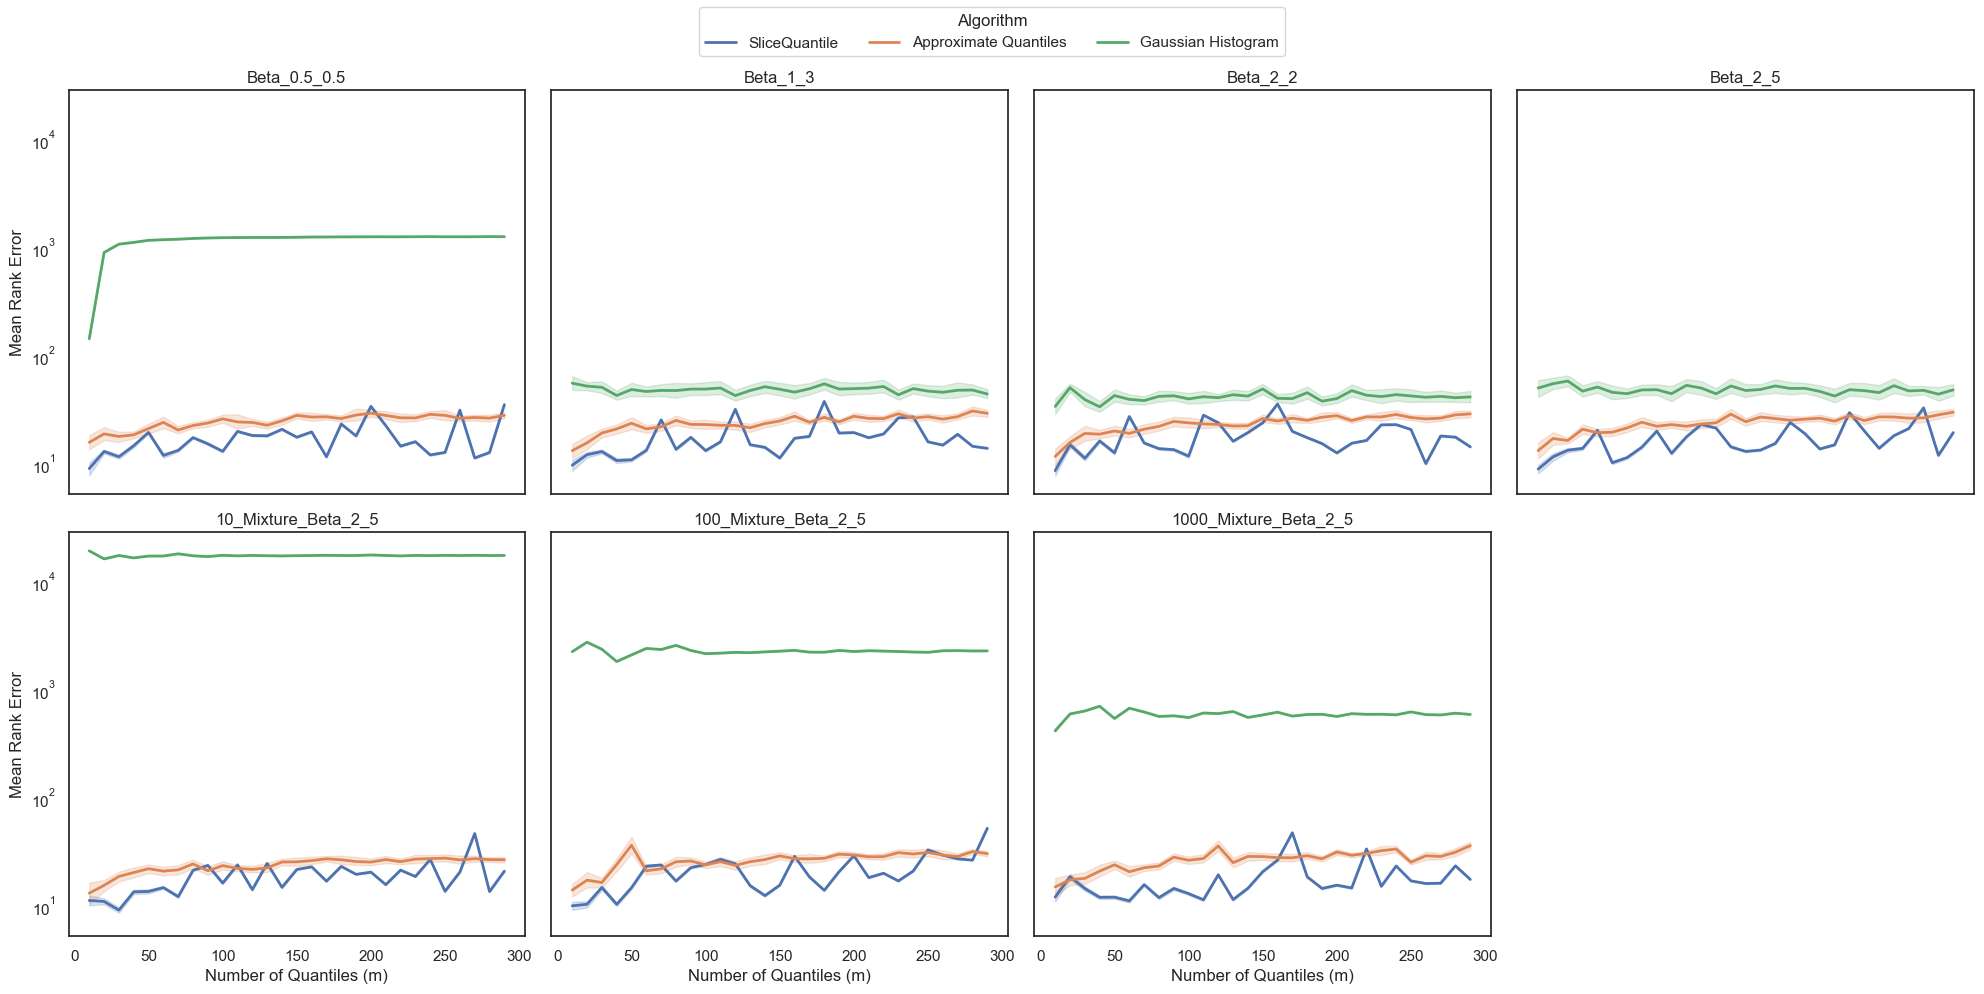

In [65]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each dataset
for i, (key, data) in enumerate(DATASET.items()):
    ax = axes[i]
    df = DF[DF["dataset"] == key]
    sns.lineplot(
        data=df,
        x="m",
        y="mean_error",
        hue="Algorithm",
        errorbar=('ci', 95),  # confidence interval 95%
        linewidth=2,
        ax=ax,
    )
    ax.set_title(key)
    ax.set_xlabel("Number of Quantiles (m)")
    ax.set_ylabel("Mean Rank Error")
    ax.set_yscale("log")
    ax.legend().remove()  # Remove individual legends

# Remove unused subplots
if len(DATASET) < len(axes):
    for j in range(len(DATASET), len(axes)):
        fig.delaxes(axes[j])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title="Algorithm")

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()